<a href="https://colab.research.google.com/github/islemmbarki/PFE/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [3]:
import numpy as np
import cv2 as cv2

from math import ceil, sqrt, cos, pi
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.cm as cm
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import Normalize

### Génération d'images au format PPM

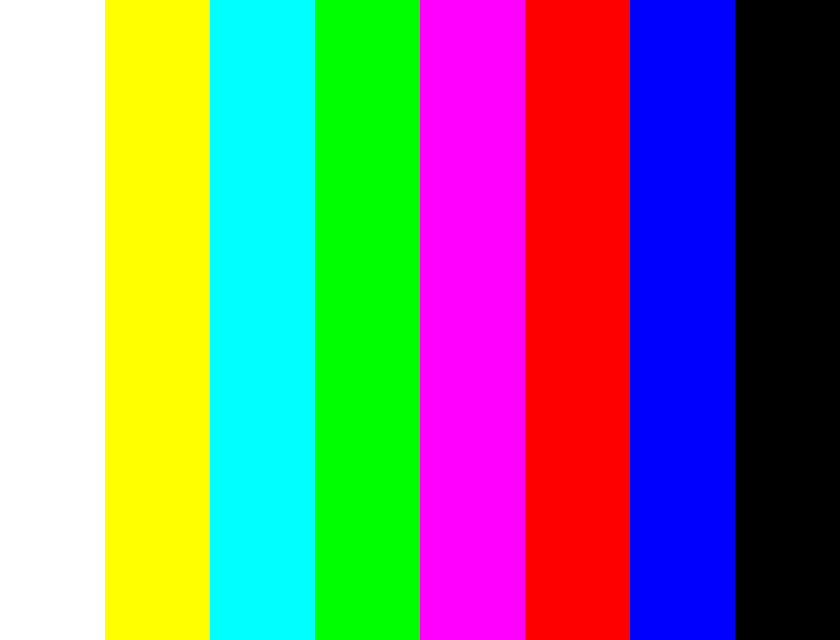

In [4]:
black   = (0,0,0)
white   = (255,255,255)
red     = (255,0,0)
green   = (0,255,0)
blue    = (0,0,255)
cyan    = (0,255,255)
yellow  = (255,255,0)
magenta = (255,0,255)
purple  = (127,0,255)
gray    = (127,127,127)
orange  = (255,127,0)


def rectangle(file, color, l, h):
    for i in range(l) :
        for j in range(h) :
            file.write('{}\n'.format(color[0]))
            file.write('{}\n'.format(color[1]))
            file.write('{}\n'.format(color[2]))

def circle(file, color, l, h, ray=0):

    abscisse = l//2     # abscisse du centre du cercle
    ordinate = h//2     # ordonnée du centre du cercle
    b=int((ray+0.5)**2) # distance maximale entre un pixel et le centre

    for i in range(h):
        for j in range(l):
            if (j-abscisse)**2+(i-ordinate)**2 in range(0,b):
                file.write('{0} {1} {2} \n'.format(color[0], color[1], color[2]))
            else :
                file.write('{0} {1} {2} \n'.format(white[0], white[1], white[2]))

def rainbow(file, h):

    for ligne in range(h):
        for x in range(1280):
            if (0 <= x) and (x <= 255):
                r, v, b = 255, x, 0
            elif (256 <= x) and (x <= 511):
                r, v, b = 511-x, 255, 0
            elif (512 <= x) and (x <= 767):
                r, v, b = 0, 255, x-512
            elif (768 <= x) and (x <= 1023):
                r, v, b = 0, 1023-x, 255
            else:
                r, v, b = x-1024, 0, 255

            file.write('{} {} {} \n'.format(r, v, b))
        file.write('\n')

def mire(file, l, h):

    colors = [white, yellow, cyan, green, magenta, red, blue, black]

    for ligne in range(h):
        for x in range(l):
            for j in range(0,8):
                if (j*(l//8) <= x) and (x <= (j+1)*(l//8)):
                    color = colors[j]
            file.write('{}\n'.format(color[0]))
            file.write('{}\n'.format(color[1]))
            file.write('{}\n'.format(color[2]))

width, height = 840, 640	# output format VGA

path='in.ppm'

f = open(path, 'w')
f.write('P3\n')						      # P3 en ligne 1 pour déclarer le format .ppm puis passage à la ligne
f.write('# PPM file generation\n')
f.write('{} {}\n'.format(width, height))  # Largeur et hauteur de l'image, séparées par un espace
f.write('255\n')						  # Maximum d'intensité des composantes

#circle(f, red, width, height, ray=100)
#rectangle(f, blue, width, height)
mire(f, width, height)

f.close()
from google.colab.patches import cv2_imshow

# Votre code pour lire l'image
ppm_image = cv2.imread(path)

# Afficher l'image
cv2_imshow(ppm_image)




cv2.waitKey(0)
cv2.destroyAllWindows()

### Affichage de l'image originale

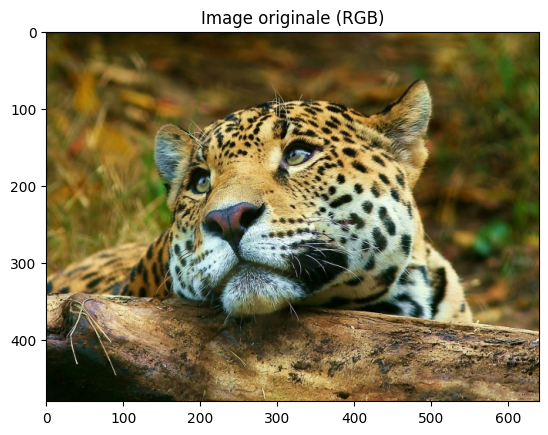

In [5]:
path='cheetah.jpg'
#path='pixelArt.jpg'
image = img.imread(path)
plt.title("Image originale (RGB)")
plt.imshow(image)
plt.show()

### Conversion de l'espace des couleurs (RGB --> YUV)

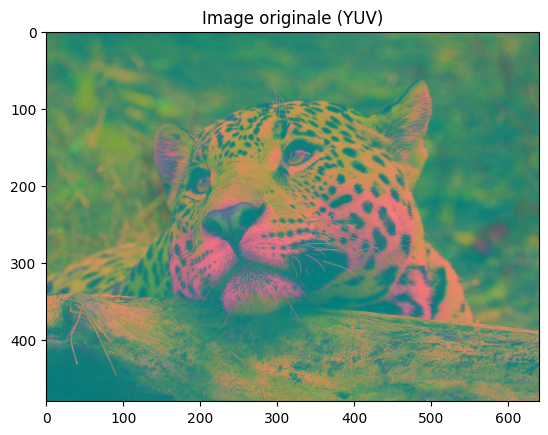

In [6]:
def rgb_to_ycrcb(im):

    xform = np.array([[.299, .587, .114], [.5, -.4187, -.0813], [-.1687, -.3313, .5]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128

    return np.uint8(ycbcr)


img_ycrcb = rgb_to_ycrcb(image)
plt.title("Image originale (YUV)")
plt.imshow(img_ycrcb)

plt.show()

### Visualisation des canaux Y, Cr, Cb

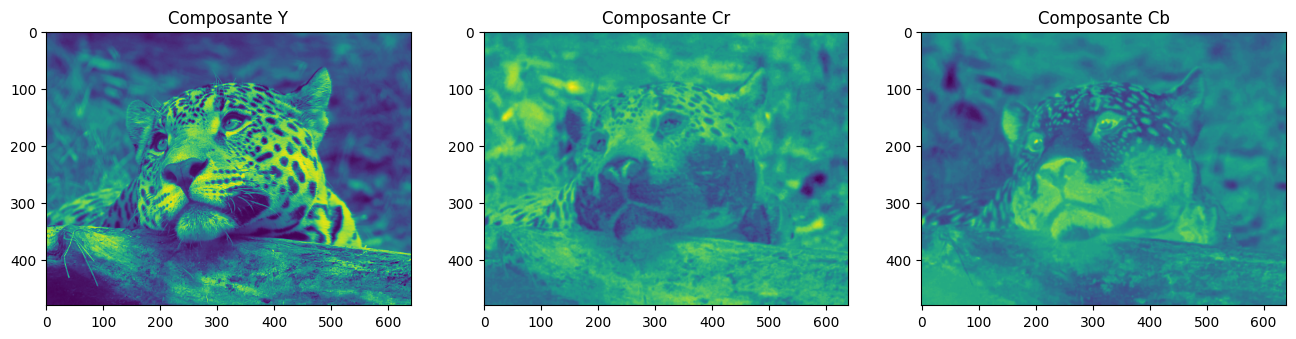

In [7]:
y, cr, cb = img_ycrcb[:,:,0], img_ycrcb[:,:,1], img_ycrcb[:,:,2]
y = np.array(y).astype(np.float32)
cr = np.array(cr).astype(np.float32)
cb = np.array(cb).astype(np.float32)

fig=plt.figure(figsize=(16,10))
fig.add_subplot(1, 3, 1)
plt.title("Composante Y")
plt.imshow(y)

fig.add_subplot(1, 3, 2)
plt.title("Composante Cr")
plt.imshow(cr)

fig.add_subplot(1, 3, 3)
plt.title("Composante Cb")
plt.imshow(cb)

plt.show()

### Calcul de taille de l'image d'origine

In [8]:
totalNumberOfBitsWithoutCompression = len(y) * len(y[0]) * 8 + len(cr) * len(cr[0]) * 8 + len(cb) * len(cb[0]) * 8
print("Total number of bits without compression (Y, Cr, Cb): {}".format(totalNumberOfBitsWithoutCompression))

Total number of bits without compression (Y, Cr, Cb): 7372800


### Chroma subsampling (4:4:4 --> 4:2:0)

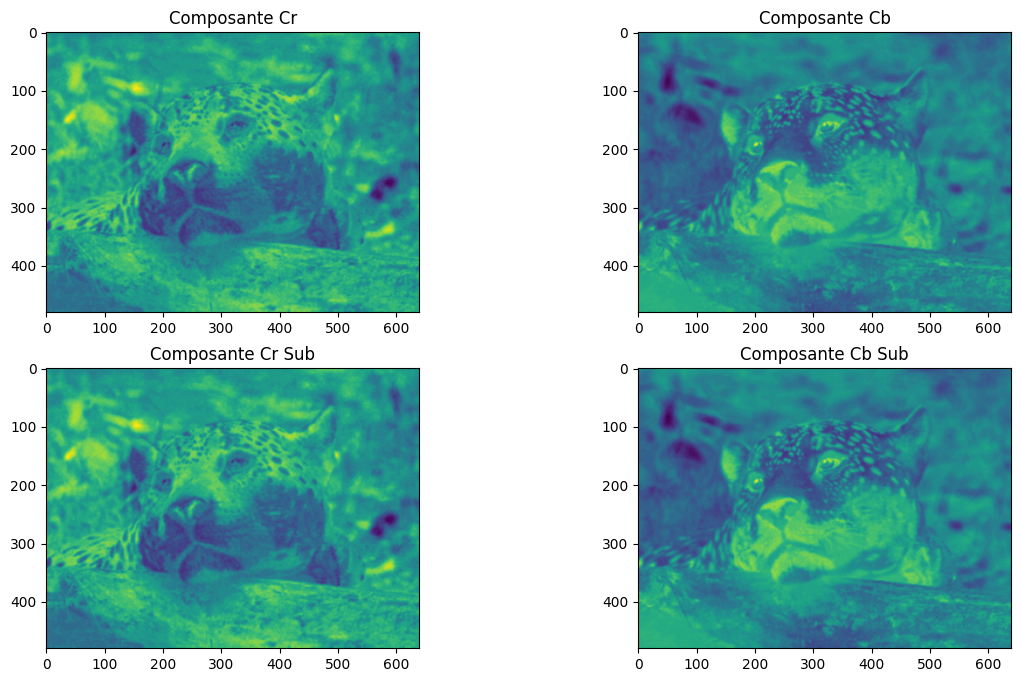

In [9]:
 # ******** Chroma subsampling 4:2:0 ******* #
crSub = cr.copy()
# Vertically, every second element equals to element above itself.
crSub[1::2, :] = crSub[::2, :]
crSub[:, 1::2] = crSub[:, ::2]

cbSub = cb.copy()
# Horizontally, every second element equals to the element on its left side.
cbSub[1::2, :] = cbSub[::2, :]
cbSub[:, 1::2] = cbSub[:, ::2]


fig=plt.figure(figsize=(14,8))
fig.add_subplot(2, 2, 1)
plt.title("Composante Cr")
plt.imshow(cr)

fig.add_subplot(2, 2, 2)
plt.title("Composante Cb")
plt.imshow(cb)

fig.add_subplot(2, 2, 3)
plt.title("Composante Cr Sub")
plt.imshow(crSub)

fig.add_subplot(2, 2, 4)
plt.title("Composante Cb Sub")
plt.imshow(cbSub)

plt.show()

### Découpage en bloc (segmentation) et Zero padding

Block size:  8
Frame dimension:  (480, 640)
Number of blocks in height:  60
Number of blocks in width:  80
Total number of blocks:  4800

--> Zero padding is not required


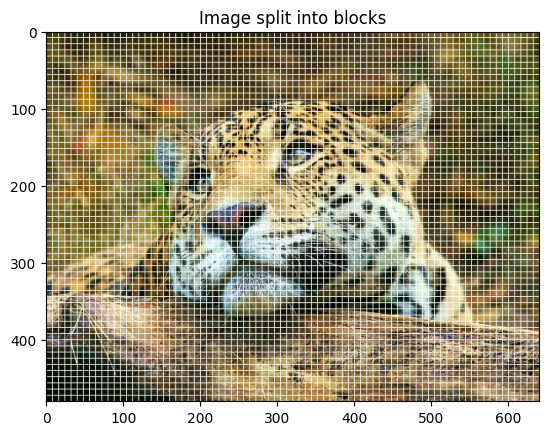

In [10]:
def show_gridding(image, h, w, blocksize):
    image=image[:h,:w]
    PIL_image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(PIL_image)
    y_start = 0
    y_end = PIL_image.height

    for x in range(0, PIL_image.width, blocksize):
        line = ((x, y_start), (x, y_end))
        draw.line(line, fill=(255,255,255))

    x_start = 0
    x_end = PIL_image.width

    for y in range(0, PIL_image.height, blocksize):
        line = ((x_start, y), (x_end, y))
        draw.line(line, fill=(255,255,255))
    #print("Number of rows: {}, Number of cols: {}".format(int(y_end/blocksize),int(x_end/blocksize)))
    plt.title("Image split into blocks")

    return plt.imshow(PIL_image)


blockSize = 8
print("Block size: ", blockSize)

# ******** Image padding ******* #
# Pad the image, because sometime image size is not dividable to block size
height = y.shape[0]
width = y.shape[1]
print("Frame dimension: ", y.shape)

h = np.float32(height)
w = np.float32(width)

# Number of blocks in height (nbh)
nbh = ceil(h / blockSize)
nbh = np.int32(nbh)
print("Number of blocks in height: ", nbh)

# Number of blocks in width (nbw)
nbw = ceil(w / blockSize)
nbw = np.int32(nbw)
print("Number of blocks in width: ", nbw)

print("Total number of blocks: ", (nbh*nbw))

# height and width of padded image
heightPadded = blockSize * nbh
widthPadded  = blockSize * nbw

show_gridding(image, heightPadded, widthPadded, blockSize)

# check if padding is needed
if (height % blockSize == 0) and (width % blockSize == 0):
    yPadded  = y.copy()
    crPadded = crSub.copy()
    cbPadded = cbSub.copy()
    print("\n--> Zero padding is not required")

### DCT (*Discrete Cosine Transform*), Quantification et Zig-zag

In [11]:
QLevel = input("Enter the quality level (0-100): ")
QLevel = int(QLevel)
print("Quality level:", QLevel)

Enter the quality level (0-100): 99
Quality level: 99


DCT and Quantization for each channels (Y,Cr,Cb)...


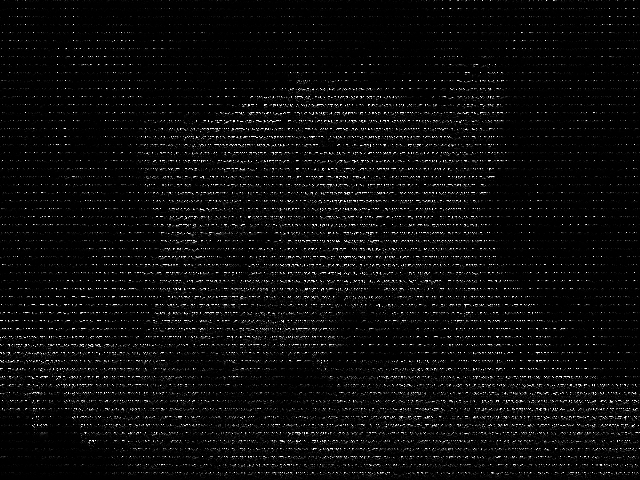

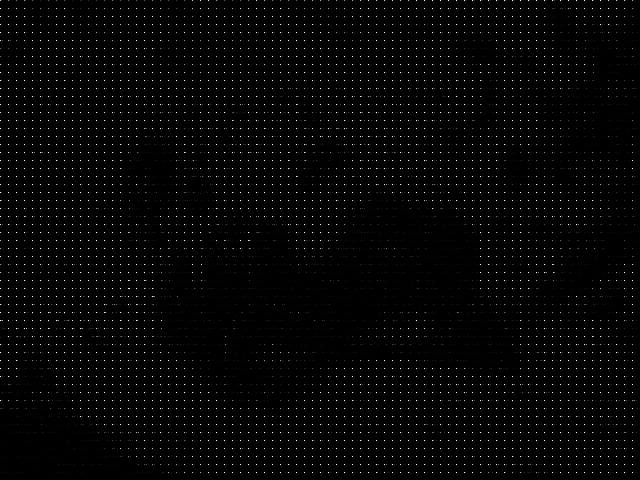

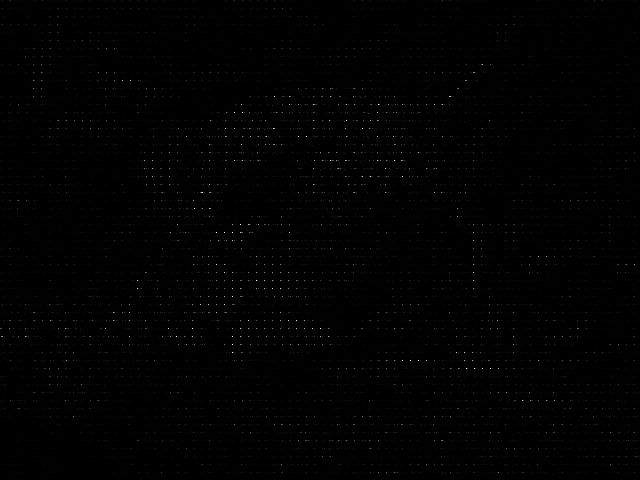

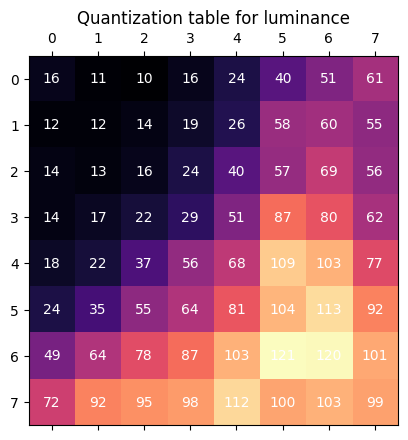

In [12]:
QTY = np.array([
    [16, 11, 10, 16,  24,  40,  51,  61],  # luminance quantization table
    [12, 12, 14, 19,  26,  58,  60,  55],
    [14, 13, 16, 24,  40,  57,  69,  56],
    [14, 17, 22, 29,  51,  87,  80,  62],
    [18, 22, 37, 56,  68, 109, 103,  77],
    [24, 35, 55, 64,  81, 104, 113,  92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103,  99]])

QTC = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],  # chrominance quantization table
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]])

def zigzag(input):

    h = 0
    v = 0
    v_min = 0
    h_min = 0
    v_max = input.shape[0]
    h_max = input.shape[1]
    i = 0
    output = np.zeros((v_max * h_max))

    while (v < v_max) and (h < h_max):

        if ((h + v) % 2) == 0:  # going up
            if v == v_min:
                output[i] = input[v, h]  # if we got to the first line
                if h == h_max:
                    v = v + 1
                else:
                    h = h + 1
                i = i + 1
            elif (h == h_max - 1) and (v < v_max):  # if we got to the last column
                output[i] = input[v, h]
                v = v + 1
                i = i + 1
            elif (v > v_min) and (h < h_max - 1):  # all other cases
                output[i] = input[v, h]
                v = v - 1
                h = h + 1
                i = i + 1
        else:

            if (v == v_max - 1) and (h <= h_max - 1):  # if we got to the last line
                output[i] = input[v, h]
                h = h + 1
                i = i + 1
            elif h == h_min:  # if we got to the first column
                output[i] = input[v, h]
                if v == v_max - 1:
                    h = h + 1
                else:
                    v = v + 1
                    i = i + 1
            elif (v < v_max - 1) and (h > h_min):  # all other cases
                output[i] = input[v, h]
                v = v + 1
                h = h - 1
                i = i + 1

        if (v == v_max - 1) and (h == h_max - 1):  # bottom right element
            output[i] = input[v, h]
            break

    return output

def quantization(QLevel, channel):

    Q = np.zeros([blockSize, blockSize])

    if channel == 'luminance' :
        Q_mat = QTY
    else:
        Q_mat = QTC

    if QLevel < 50 and QLevel > 1:
        Q = (50 / QLevel) * Q_mat

    elif QLevel < 100:
        Q = ((100 - QLevel) / 50) * Q_mat

    else:
        print("Quality Level must be in the range [1..99]")

    return Q

def myDCT(block, channel, quality):

    T = np.zeros([blockSize, blockSize])
    M = np.zeros([blockSize, blockSize])

    for i in range(blockSize):
        for j in range(blockSize):
            M[i][j] = block[i][j] - 128
            if i == 0:
                T[i][j] = sqrt(1/blockSize)
            else:
                T[i][j] = sqrt(2/blockSize)*cos((2*j+1)*i*pi/(2*blockSize))

    T = np.array(T)

    D = (T.dot(M)).dot(np.transpose(T))

    Q = quantization(quality, channel)

    for i in range(blockSize):
        for j in range(blockSize):
            if Q[i][j] > 255:
                Q[i][j] = 255

    C = np.divide(D, Q)
    C = np.round(C)

    return C

print("DCT and Quantization for each channels (Y,Cr,Cb)...")

yDct_avg = np.zeros((8,8))
crDct_avg = np.zeros((8,8))
cbDct_avg = np.zeros((8,8))


for i in range(nbh):
    # Start and end row index of the block
    row_ind_1 = i*blockSize
    row_ind_2 = row_ind_1+blockSize

    for j in range(nbw):
        # Start and end column index of the block
        col_ind_1 = j*blockSize
        col_ind_2 = col_ind_1+blockSize

        yBlock = yPadded[row_ind_1:row_ind_2, col_ind_1:col_ind_2]
        crBlock = crPadded[row_ind_1:row_ind_2, col_ind_1:col_ind_2]
        cbBlock = cbPadded[row_ind_1:row_ind_2, col_ind_1:col_ind_2]

        '''
        #With the official function dct() provide by OpenCV2
        yDct  = cv2.dct(yBlock)
        crDct = cv2.dct(crBlock)
        cbDct = cv2.dct(cbBlock)

        yDct  = np.divide(yDct, QTY).astype(np.int32)
        crDct = np.divide(crDct, QTC).astype(np.int32)
        cbDct = np.divide(cbDct, QTC).astype(np.int32)
        '''

        yDct = myDCT(yBlock, channel='luminance', quality=QLevel)
        crDct = myDCT(crBlock, channel='chrominance', quality=QLevel)
        cbDct = myDCT(cbBlock, channel='chrominance', quality=QLevel)

        yDct_avg += yDct
        crDct_avg += crDct
        cbDct_avg += cbDct

        yZigzag  = np.reshape(zigzag(yDct), (blockSize, blockSize))
        crZigzag = np.reshape(zigzag(crDct), (blockSize, blockSize))
        cbZigzag = np.reshape(zigzag(cbDct), (blockSize, blockSize))

        yPadded [row_ind_1:row_ind_2, col_ind_1:col_ind_2] = yZigzag
        crPadded[row_ind_1:row_ind_2, col_ind_1:col_ind_2] = crZigzag
        cbPadded[row_ind_1:row_ind_2, col_ind_1:col_ind_2] = cbZigzag

yDct_block_avg= np.divide((yDct_avg),(nbh*nbw))
crDct_block_avg= np.divide((crDct_avg),(nbh*nbw))
cbDct_block_avg= np.divide((cbDct_avg),(nbh*nbw))

from google.colab.patches import cv2_imshow

# Votre code pour calculer les DCT et les quantifications

# Afficher les images DCT
cv2_imshow(yPadded)
cv2_imshow(crPadded)
cv2_imshow(cbPadded)


fig, ax = plt.subplots()
ax.matshow(QTY, cmap='magma')
for (i, j), z in np.ndenumerate(QTY):
    ax.text(j, i, z, ha='center', va='center', color='white')
plt.title("Quantization table for luminance")
plt.show()

'''
fig=plt.figure(figsize=(16,14))
fig.add_subplot(3, 1, 1)
plt.imshow(yPadded, cmap='gray', vmax = np.max(yPadded)*0.01,vmin = 0)
plt.title('Luminance Y after DCT (QLevel = ' + str(QLevel) + ')')

fig.add_subplot(3, 1, 2)
plt.imshow(crPadded, cmap='gray', vmax = np.max(crPadded)*0.25,vmin = 0)
plt.title('Chrominance Cr after DCT (QLevel = ' + str(QLevel) + ')')

fig.add_subplot(3, 1, 3)
plt.imshow(cbPadded, cmap='gray', vmax = np.max(cbPadded)*0.25,vmin = 0)
plt.title('Chrominance Cb after DCT (QLevel = ' + str(QLevel) + ')')

fig=plt.figure(figsize=(16,14))
ax = fig.add_subplot(1, 3, 1)
plt.title('Luminance Y block after DCT')
plt.xticks([0,1,2,3,4,5,6,7])
anchored_text = AnchoredText("Zeroes: "+str(yDct_block_avg.size - np.count_nonzero(yDct_block_avg)), loc=4)
ax.add_artist(anchored_text)
N255=Normalize(0,np.max(yDct_block_avg)) #Normalization object, used by imshow()
plt.imshow(yDct_block_avg,cmap=cm.jet,norm=N255,interpolation='nearest')
#plt.colorbar(shrink = 0.8)

ax = fig.add_subplot(1, 3, 2)
plt.title('Chrominance Cr block after DCT')
plt.xticks([0,1,2,3,4,5,6,7])
anchored_text = AnchoredText("Zeroes: "+str(crDct_block_avg.size - np.count_nonzero(crDct_block_avg)), loc=4)
ax.add_artist(anchored_text)
N255=Normalize(0,np.max(crDct_block_avg)) #Normalization object, used by imshow()
plt.imshow(crDct_block_avg,cmap=cm.jet,norm=N255,interpolation='nearest')
#plt.colorbar(shrink = 0.8)

ax = fig.add_subplot(1, 3, 3)
plt.title('Chrominance Cb block after DCT')
plt.xticks([0,1,2,3,4,5,6,7])
anchored_text = AnchoredText("Zeroes: "+str(cbDct_block_avg.size - np.count_nonzero(cbDct_block_avg)), loc=4)
ax.add_artist(anchored_text)
N255=Normalize(0,np.max(cbDct_block_avg)) #Normalization object, used by imshow()
plt.imshow(cbDct_block_avg,cmap=cm.jet,norm=N255,interpolation='nearest')
#plt.colorbar(shrink = 0.8)

plt.show()
'''

cv2.waitKey(0)
cv2.destroyAllWindows()

### RLE (*Run Length Encoding*) - Implémentation 1

In [13]:
def run_length_encoding(image, tuple=True):
    i = 0
    skip = 0
    stream = []
    # bitstream = ""
    while i < image.shape[0]:
        if image[i] != 0:
            if tuple == True :
                stream.append((image[i],skip))
            else:
                stream.append(image[i])
                stream.append(skip)
            skip = 0
        else:
            skip = skip + 1
        i = i + 1

    return stream

yEncoded  = run_length_encoding(yPadded.flatten(), tuple=True)
crEncoded = run_length_encoding(crPadded.flatten(), tuple=True)
cbEncoded = run_length_encoding(cbPadded.flatten(), tuple=True)

print("10 elements of luminance Y after RLE:   ", yEncoded[100:110])
print("10 elements of chrominance Cr after RLE:", crEncoded[100:110])
print("10 elements of chrominance Cb after RLE:", cbEncoded[100:110])

10 elements of luminance Y after RLE:    [(7.0, 0), (-3.0, 0), (-8.0, 0), (-2376.0, 0), (-40.0, 0), (-43.0, 0), (9.0, 0), (26.0, 0), (14.0, 0), (-1.0, 0)]
10 elements of chrominance Cr after RLE: [(-12.0, 0), (-14.0, 0), (3.0, 0), (-5.0, 1), (-2.0, 0), (-2.0, 0), (128.0, 0), (-6.0, 0), (-27.0, 0), (1.0, 0)]
10 elements of chrominance Cb after RLE: [(-403.0, 0), (9.0, 0), (27.0, 0), (-4.0, 0), (-7.0, 0), (2.0, 0), (-3.0, 1), (-419.0, 0), (-6.0, 0), (35.0, 0)]


### Codage de Huffman (code à longueur variable)

In [14]:
from collections import Counter

def get_freq_dict(array: list) -> dict:
    """
    returns a dict where the keys are the values of the array, and the values are their frequencies
    :param numpy.ndarray array: intermediary stream as array
    :return: frequency table
    """

    data = Counter(array)
    result = {k: round(d / len(array),3) for k, d in data.items()}
    return result

def find_huffman(p: dict) -> dict:
    """
    returns a Huffman code for an ensemble with distribution p
    :param dict p: frequency table
    :returns: huffman code for each symbol
    """
    # Base case of only two symbols, assign 0 or 1 arbitrarily; frequency does not matter
    if len(p) == 2:
        return dict(zip(p.keys(), ['0', '1']))

    # Create a new distribution by merging lowest probable pair
    sorted_p = sorted(p.items(), key=lambda x: x[1])
    a1, a2 = sorted_p[0][0], sorted_p[1][0]
    p_prime = p.copy()
    p1, p2 = p_prime.pop(a1), p_prime.pop(a2)
    p_prime[a1 + a2] = p1 + p2

    # Recurse and construct code on new distribution
    import sys

# Définir la profondeur maximale de récursion
    sys.setrecursionlimit(10000)  # Remplacez 10000 par la valeur souhaitée

# Votre code ici...

    c = find_huffman(p_prime)
    ca1a2 = c.pop(a1 + a2)
    c[a1], c[a2] = ca1a2 + '0', ca1a2 + '1'

    return c


yFrequencyTable = get_freq_dict(yEncoded)
yHuffman = find_huffman(yFrequencyTable)
yFreq = sorted(yFrequencyTable.items(), key=lambda x: x[1], reverse=True)
yBitsToTransmit = str()
for value in yEncoded:
    yBitsToTransmit += yHuffman[value]


crFrequencyTable = get_freq_dict(crEncoded)
crHuffman = find_huffman(crFrequencyTable)
crFreq = sorted(crFrequencyTable.items(), key=lambda x: x[1], reverse=True)
crBitsToTransmit = str()
for value in crEncoded:
    crBitsToTransmit += crHuffman[value]

cbFrequencyTable = get_freq_dict(cbEncoded)
cbHuffman = find_huffman(cbFrequencyTable)
cbFreq = sorted(cbFrequencyTable.items(), key=lambda x: x[1], reverse=True)
cbBitsToTransmit = str()
for value in cbEncoded:
    cbBitsToTransmit += cbHuffman[value]

file = open("CompressedImage.asfh", "w")
if file.writable():
    file.write(yBitsToTransmit + "\n" + crBitsToTransmit + "\n" + cbBitsToTransmit)
file.close()

totalNumberOfBitsAfterCompression = len(yBitsToTransmit) + len(crBitsToTransmit) + len(cbBitsToTransmit)
print("Total number of bits after compression: {}".format(totalNumberOfBitsAfterCompression))
print("Compression rate (%): {:.2f}".format((1-(totalNumberOfBitsAfterCompression/totalNumberOfBitsWithoutCompression))*100))
#print("Compression Ratio for Y channel: " + str(np.round(totalNumberOfBitsWithoutCompression / totalNumberOfBitsAfterCompression, 1)))


y_list_code = []
for y_code in yHuffman.values():
    y_list_code.append(y_code)

cr_list_code = []
for cr_code in crHuffman.values():
    cr_list_code.append(cr_code)

cb_list_code = []
for cb_code in cbHuffman.values():
    cb_list_code.append(cb_code)


sumY = 0
sumCr = 0
sumCb = 0
print("\n---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("\t\t     Luminance Y\t\t\t|\t\t\tChrominance Cr\t\t\t\t|\t\t\tChrominance Cb")
print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Symbol","\t\tProbability","\tCode","\t\tLength  |",
     "\tSymbol","\t\tProbability","\tCode","\t\tLength  |",
     "\tSymbol","\t\tProbability","\tCode","\t\tLength")
print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
for i in range(0,10):
    print(str(yFreq[i][0])+ "\t"+ str(yFreq[i][1])+ "\t\t"+ str(y_list_code[i]) +"\t\t"+ str(len(y_list_code[i])) +
    "\t|\t" + str(crFreq[i][0])+ "\t"+ str(crFreq[i][1])+ "\t\t"+ str(cr_list_code[i]) + "\t\t"+ str(len(cr_list_code[i])) +
    "\t|\t" + str(cbFreq[i][0])+ "\t"+ str(cbFreq[i][1])+ "\t\t"+ str(cb_list_code[i]) + "\t\t"+ str(len(cr_list_code[i])))
    sumY += (yFreq[i][1])
    sumCr += (crFreq[i][1])
    sumCb += (cbFreq[i][1])
print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Total\t\t{:.2f}\t\t\t\t\t|\tTotal\t\t{:.2f}\t\t\t\t\t|\tTotal\t\t{:.2f}".format(sumY*100, sumCr*100, sumCb*100))
print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

Total number of bits after compression: 3398390
Compression rate (%): 53.91

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
		     Luminance Y			|			Chrominance Cr				|			Chrominance Cb
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Symbol 		Probability 	Code 		Length  | 	Symbol 		Probability 	Code 		Length  | 	Symbol 		Probability 	Code 		Length
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
(-1.0, 0)	0.075		1110		4	|	(-1.0, 0)	0.093		010		3	|	(-1.0, 0)	0.094		010		3
(1.0, 0)	0.074		1111		4	|	(1.0, 0)	0.091		000		3	|	(1.0, 0)	0.091		001		3
(2.0, 0)	0.042		0010		4	|	(-2.0, 0)	0.041	

### Décompression (avec transmission de la table de Huffman)

In [15]:

# ************************************************************************ #
#                                   --> TODO                               #
# ************************************************************************ #

### RLD (*Run Length Decoding*)

In [16]:
def run_length_decoding(encoded, h, w):

    i = 0
    skip = 0
    image = []
    while i != len(encoded):
        if encoded[i][1] != 0:
            while skip != (encoded[i][1]):
                image.append(0)
                skip = skip + 1
        image.append(encoded[i][0])
        i = i + 1
        skip = 0

    if i == len(encoded):
        for _ in range(0, ((h*w)-len(image))):
            image.append(0)

    return image


yRld = run_length_decoding(yEncoded, height, width)
crRld = run_length_decoding(crEncoded, height, width)
cbRld = run_length_decoding(cbEncoded, height, width)

yDecoded  = np.reshape(yRld, (height, width))
crDecoded = np.reshape(crRld, (height, width))
cbDecoded = np.reshape(cbRld, (height, width))

print("First elements for luminance Y after Run Length Decoding:   ", yRld[:15])
print("First elements for chrominance Cr after Run Length Decoding:", crRld[:15])
print("First elements for chrominance Cb after Run Length Decoding:", cbRld[0:15])

First elements for luminance Y after Run Length Decoding:    [-1980.0, -5.0, -133.0, 9.0, 49.0, 1.0, -8.0, 7.0, -1839.0, -57.0, -228.0, -4.0, -6.0, -42.0, -8.0]
First elements for chrominance Cr after Run Length Decoding: [210.0, 12.0, -4.0, -5.0, 6.0, -1.0, -1.0, 3.0, 129.0, 24.0, -5.0, 4.0, 6.0, 8.0, 1.0]
First elements for chrominance Cb after Run Length Decoding: [-550.0, 5.0, 34.0, -2.0, -7.0, -2.0, -1.0, 5.0, -622.0, 20.0, 59.0, -1.0, -4.0, 7.0, 1.0]


### Inverse Zig-Zag, IDCT (*Inverse Discrete Cosine Transform*) & Dé-quantification

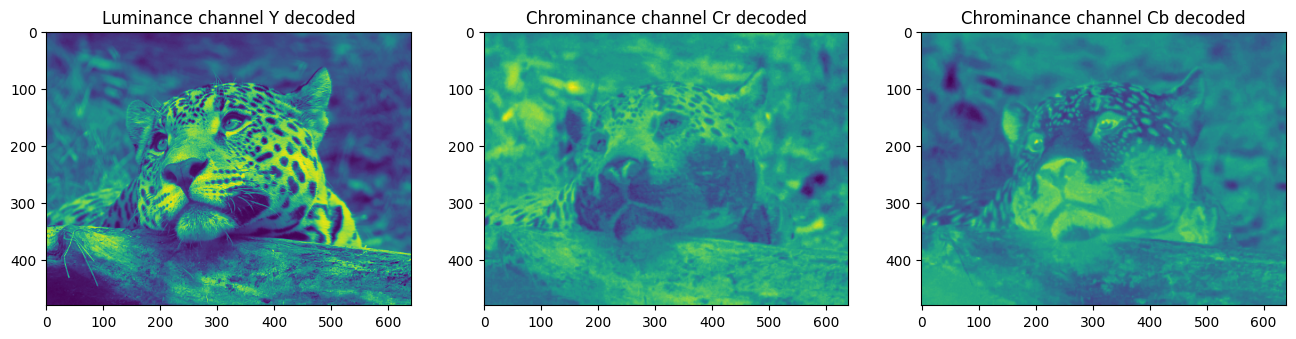

In [17]:
def inverse_zigzag(input, vmax, hmax):

	h = 0
	v = 0
	vmin = 0
	hmin = 0
	output = np.zeros((vmax, hmax))
	i = 0

	while ((v < vmax) and (h < hmax)):
		if ((h + v) % 2) == 0:                 # going up
			if (v == vmin):
				output[v, h] = input[i]        # if we got to the first line
				if (h == hmax):
					v = v + 1
				else:
					h = h + 1
				i = i + 1
			elif ((h == hmax -1 ) and (v < vmax)):   # if we got to the last column
				output[v, h] = input[i]
				v = v + 1
				i = i + 1
			elif ((v > vmin) and (h < hmax -1 )):    # all other cases
				output[v, h] = input[i]
				v = v - 1
				h = h + 1
				i = i + 1
		else:                                    # going down
			if ((v == vmax -1) and (h <= hmax -1)):       # if we got to the last line
				output[v, h] = input[i]
				h = h + 1
				i = i + 1
			elif (h == hmin):                  # if we got to the first column
				output[v, h] = input[i]
				if (v == vmax -1):
					h = h + 1
				else:
					v = v + 1
				i = i + 1
			elif((v < vmax -1) and (h > hmin)):     # all other cases
				output[v, h] = input[i]
				v = v + 1
				h = h - 1
				i = i + 1

		if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
			output[v, h] = input[i]
			break

	return output

def myIDCT(block, channel):

    T = np.zeros([blockSize,blockSize])
    R = np.zeros([blockSize,blockSize])

    for i in range(blockSize):
        for j in range(blockSize):
            if (i == 0):
                T[i][j] = sqrt(1/blockSize)
            else:
                T[i][j] = sqrt(2/blockSize)*cos((2*j+1)*i*pi/(2*blockSize))

    Q = quantization(QLevel, channel)

    for i in range(blockSize):
        for j in range(blockSize):
            R[i][j] = Q[i][j] * block[i][j]

    N = (np.transpose(T).dot(R)).dot(T)

    for i in range(blockSize):
        for j in range(blockSize):
            N[i][j] += 128

    return N

yPadded = np.zeros((height, width))
crPadded = np.zeros((height, width))
cbPadded = np.zeros((height, width))

for i in range(nbh):
    row_ind_1 = i*blockSize
    row_ind_2 = row_ind_1+blockSize

    for j in range(nbw):
        col_ind_1 = j*blockSize
        col_ind_2 = col_ind_1+blockSize

        yBlock = yDecoded[row_ind_1:row_ind_2, col_ind_1:col_ind_2]
        crBlock = crDecoded[row_ind_1:row_ind_2, col_ind_1:col_ind_2]
        cbBlock = cbDecoded[row_ind_1:row_ind_2, col_ind_1:col_ind_2]

        yBlock = inverse_zigzag((yBlock.flatten()), blockSize, blockSize)
        crBlock = inverse_zigzag((crBlock.flatten()), blockSize, blockSize)
        cbBlock = inverse_zigzag((cbBlock.flatten()), blockSize, blockSize)

        '''
        yDequantize = np.multiply(yBlock,QTY)
        crDequantize = np.multiply(crBlock,QTC)
        cbDequantize = np.multiply(cbBlock,QTC)

        yIdct  = cv2.idct(yDequantize)
        crIdct = cv2.idct(crDequantize)
        cbIdct = cv2.idct(cbDequantize)
		'''

        yIdct = myIDCT(yBlock, channel='luminance')
        crIdct = myIDCT(crBlock, channel='chrominance')
        cbIdct = myIDCT(cbBlock, channel='chrominance')

        yPadded[row_ind_1:row_ind_2, col_ind_1:col_ind_2] = np.reshape(yIdct, (blockSize, blockSize))
        crPadded[row_ind_1:row_ind_2, col_ind_1:col_ind_2] = np.reshape(crIdct, (blockSize, blockSize))
        cbPadded[row_ind_1:row_ind_2, col_ind_1:col_ind_2] = np.reshape(cbIdct, (blockSize, blockSize))


fig=plt.figure(figsize=(16,16))
fig.add_subplot(1, 3, 1)
plt.title('Luminance channel Y decoded')
plt.imshow(np.uint8(yPadded))

fig.add_subplot(1, 3, 2)
plt.title('Chrominance channel Cr decoded')
plt.imshow(np.uint8(crPadded))

fig.add_subplot(1, 3, 3)
plt.title('Chrominance channel Cb decoded')
plt.imshow(np.uint8(cbPadded))

plt.show()

### Conversion de l'espace des couleurs (YUV --> RGB) & Visualisation des différences avec l'image d'origine

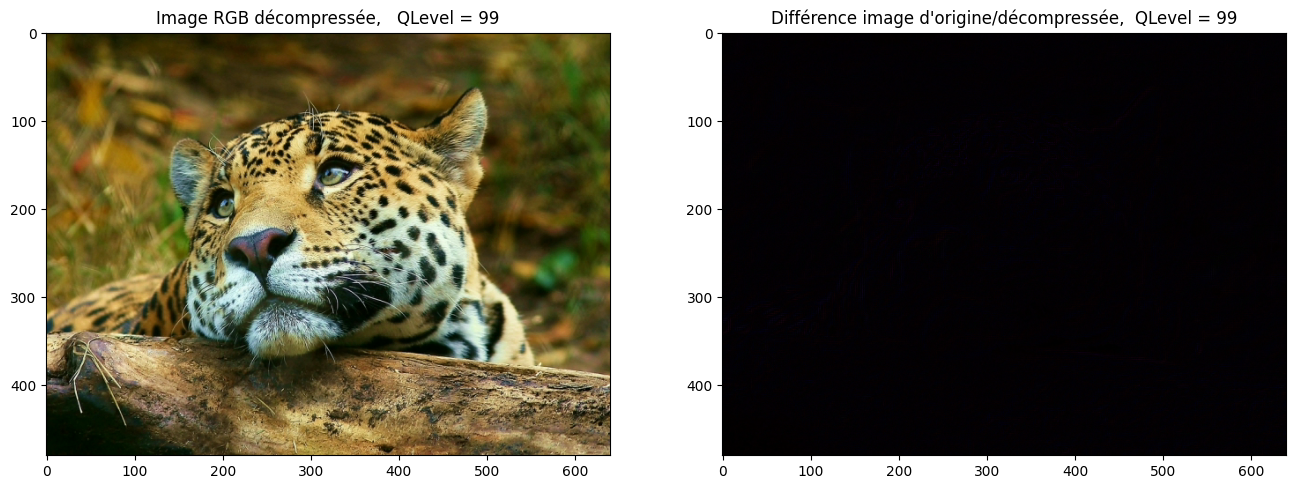

Correspondance des points caractéristiques (0 is a perfect match): 5.24


In [18]:
def ycrcb_to_rgb(im):

    xform = np.array([[1, 1.402, 0], [1, -.71414, -0.34414], [1, 0, 1.772]])
    rgb = im.astype(float) # np.float generate warning
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)

    return np.uint8(rgb)


img_ycrcb[:, :, 0] = yPadded
img_ycrcb[:, :, 1] = crPadded
img_ycrcb[:, :, 2] = cbPadded
res = ycrcb_to_rgb(img_ycrcb)

fig=plt.figure(figsize=(16,10))
fig.add_subplot(1, 2, 1)
plt.title("Image RGB décompressée,   QLevel = "+str(QLevel))
plt.imshow(res)

diff = image.copy()
cv2.absdiff(image, res, diff)

fig.add_subplot(1,2,2)
plt.title("Différence image d'origine/décompressée,  QLevel = "+str(QLevel))
plt.imshow(diff)

plt.show()

'''
Correspondance des points caractéristiques :
 - extraction des points caractéristiques de l'image et comparaison de leurs distances.
 - la conversion de l'échelle de gris est effectuée pour améliorer la précision d'extraction.
 - si la valeur obtenue vaut 0, alors il y a une correspondance parfaite entre les 2 images.
More informations here : https://linuxtut.com/fr/c9497ffb5240622ede01/
'''

image2  = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
res2 = cv2.cvtColor(res, cv2.COLOR_RGB2GRAY)
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
detector = cv2.ORB_create()
#detector = cv2.AKAZE_create()
(target_kp, target_des) = detector.detectAndCompute(image2, None)
(comparing_kp, comparing_des) = detector.detectAndCompute(res2, None)
matches = bf.match(target_des, comparing_des)
dist = [m.distance for m in matches]
ret = np.sum(dist) / len(dist)
print("Correspondance des points caractéristiques (0 is a perfect match): {:.2f}".format(ret))

### Export au format PPM (*Portable PixMap file format*)

In [19]:
def write_lines_to_file(data, filename: str, file_format: str = None):
    # Add extension to the filename if needed
    if file_format is not None and not filename.lower().endswith(file_format):
        if not file_format.startswith('.'):
            file_format = "." + file_format

        filename = filename.rstrip('.') + file_format

    with open(filename, 'w') as file:
        file.write(data)

def save(filename: str, type, width, height, depth, pixels):

    ppm_file_format = "{0}\n{1}\n{2}\n{3}"

    image_string = ""
    for line in pixels:
        for pixel in line:
            image_string += "{0}\n{1}\n{2}\n".format(pixel[0], pixel[1], pixel[2])

    # Construct data string
    ppm_image = ppm_file_format.format(type,"{0} {1}".format(width, height), depth, image_string)

    write_lines_to_file(ppm_image, filename, ".ppm")


save("out.ppm", "P3", width, height, 255, res)